# Bayesian Methods for Hackers - Chapter 02 

In PyMC3, we typically handle all the variables we want in our model in the context of a the `Model` object.

In [ ]:
!pip install pymc3

In [ ]:
import pymc3 as pm

# PyMC3 Models

In [ ]:
# With PyMC3, all variables are defined in the context of a Model
with pm.Model() as model:
  parameter = pm.Exponential('poisson_param', 1.0)
  data_generator = pm.Poisson('data_generator', parameter)

In [ ]:
# Can continue to work in the context of the same model using the `with` syntax
with model:
  data_plus_one = data_generator + 1

In [ ]:
# These variables can be examined outside the scope of a model. But to define additional variables
# that the model will recognize, we still need to declare them in context
parameter.tag.test_value

array(0.69314718)

In [ ]:
# Each variable declared in a parameter's scope is defined with its own name i.e. the first string parameter
with pm.Model() as model:
  theta = pm.Exponential('theta', 2.0)                  # theta is mapped to pm.Model, and has name `theta`
  data_generator = pm.Poisson('data_generator', theta)  # data_generator is mapped to pm.Model, and has name `data_generator`

In [ ]:
# We can instantiate as many models as wel like, and need not overwrite old models
with pm.Model() as ab_testing:
  p_A = pm.Uniform('P(A)', 0, 1)
  p_B = pm.Uniform('P(B)', 0, 1)

# PyMC3 Variables

In [ ]:
# All PyMC3 variables have an initial value called the `test_value` 
print("parameter.tag.test_value = ", parameter.tag.test_value)
print("data_generator.tag.test_value = ", data_generator.tag.test_value)
print("data_plus_one.tag.test_value = ", data_plus_one.tag.test_value)

parameter.tag.test_value =  0.6931471824645996
data_generator.tag.test_value =  0
data_plus_one.tag.test_value =  1


`test_value` is only used for the model as the starting point for sampling if no other start is specified . It doesn't change the result of sampling. We can explicitly specify the initial state for `test_value` during model initialization.

In [ ]:
# Explicitly initialize test_value
with pm.Model() as model:
  parameter = pm.Exponential('poisson_param', 1.0, testval = 0.5)

In [ ]:
print("parameter.tag.test_value = ", parameter.tag.test_value)

parameter.tag.test_value =  0.5


## Deterministic vs Stochastic Variables
- A **stochastic** variable is one that is not deterministic i.e. even if we knew all the values of the variables' parameters and components beforehand, the variable would still be random.
- A **deterministic** variable is one that is not random i.e. given that we know the values of variables' parameters and components, we can also determine the value of the variable itself. 

## Initializing Stochastic Variables

In [ ]:
# A name argument + additional parameters that are class specific 
with pm.Model() as stochastic_example_model:
  some_variable = pm.DiscreteUniform('discrete_uni_var', 0, 4)      
  # Uniform RV between 0 and 4. Because `name` argument is used to fetch the posterior 
  # distribution after sampling, it is best to be descriptive. 

In [ ]:
# Can also multiple stochastic variables that are independent of each other
# Suppose we want to instantiate a uniform model with `N` betas 
N = 10

with pm.Model() as multivariate_example_model:
  betas = pm.Uniform('betas', 0, 1, shape = N)

## Initializing Deterministic Variables

In [ ]:
with pm.Model() as model:
  lambda_1 = pm.Exponential('lambda_1', 1.0)
  lambda_2 = pm.Exponential('lambda_2', 1.0)
  tau = pm.DiscreteUniform('tau', lower = 0, upper = 10)

In [ ]:
# This is a deterministic random variable: we know the component variables are lambda_1 and lambda_2
# So we know exactly what makes up new_deterministic_variable
new_deterministic_variable = lambda_1 + lambda_2

In [ ]:
# Last chapter's text-messaging example used a deterministic random variable 
import numpy as np

n_data_points = 5       # In the previous chapter we had 70 data points
idx = np.arange(n_data_points)
with model:
  lambda_ = pm.math.switch(tau >= idx, lambda_1, lambda_2)

`lambda_` or $\lambda$ is known completley if `lambda_1`, `lambda_2`, and `tau` are known, because $\lambda = f(\lambda_1, \lambda_2, \tau)$. We use the `switch` function to change from $\lambda_1$ to $\lambda_2$ at the appropriate time. 

Inside a `deterministic` variable, the stochastic variables passed in behavee like scalers or `NumPy` arrays. We can do whatever we want with them as long as the dimensions match up in our calculations.

In [ ]:
def subtract(x, y):
  return x - y

with pm.Model() as subtraction_model:
  stochastic_1 = pm.Uniform('uniform_1', 0, 1)
  stochastic_2 = pm.Uniform('uniform_2', 0, 1)

  # Must be created in the context of a model, though maybe not this model 
  det_1 = pm.Deterministic('Delta', subtract(stochastic_1, stochastic_2))

# Theano

PyMC3 runs on a theano backend.

In [ ]:
import theano.tensor as tt

with pm.Model() as theano_test:
  p1 = pm.Uniform('p', 0, 1)
  p2 = 1 - p1 
  p = tt.stack([p1, p2])

  assignment = pm.Categorical('assignment', p)

# Including Observations in Models

In [ ]:
%matplotlib inline 

from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt 
import scipy.stats as stats

At this point, we have fully specified our priors for parameters like `lambda_1`.

(0.0, 8.0)

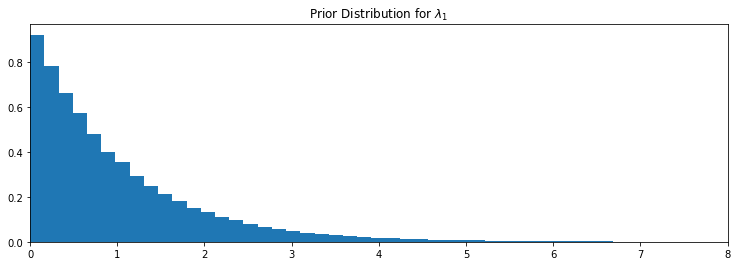

In [ ]:
# What is the distribution of `lambda_1`?
figsize(12.5, 4)
samples = lambda_1.random(size = 200000)
plt.hist(samples, bins = 70, density = True, histtype = 'stepfilled')
plt.title('Prior Distribution for $\lambda_1$')
plt.xlim([0, 8])

The next step is to include data and observations into the model. We do this using the `observed` keyword for Stochastic variables.

In [ ]:
# This is the data or evidence that will be used with our model
data = np.array([10, 5])

# For stochastic variables, we can explicitly specify the evidence/data using the `fixed` keyword
with model:
  fixed_variable = pm.Poisson('fixed', 1 , observed = data)
print('value: ', fixed_variable.tag.test_value)

value:  [10  5]


# Bayesian Modeling Workflow

A good start to Bayesian modeling is to think about **how your data might have been generated** or what the data generating process was. Ask questions like 
1. **What is the best random variable to describe the target variable?**: In the previous example, the target variable was the count of text messages received on day $i$ $C_i$. A Poisson RV was a good candidate because it could represent the discrete count data. 
2. **What variables do we need to define the data generating process?** Now that we've assumed SMS frequency is Poisson distributed, what do we need to define this distribution? We know it the Poisson distribution as a parameter $\lambda$.
3. **Do we know the parameters required to define the generating process?** In this context, do we know $\lambda$? No, and in fact we have a suspicion that there are two $\lambda$ values - one of earlier behaviur, and one for later behaviour. We don't know when the switchover happens, but we define this point with another parameter - $\tau$.
4. **What is a good distribution for the parameters?** We know an exponential distribution might be useful for $\lambda$ since it assigns probabilties to positive real numbers. Since this distribution itself has a parameter, we call it $\alpha$.
5. **Decide a first principle**. Theoretically, we could go on forever making assumptions about how $\alpha$ is generated and how the parameters that make up the distribution for $\alpha$ themselves are generated, but this gets intractable. We don't really have a strong prior belief about this parameter. So best to stop here. For $\alpha$, if we set a really high value (which corresponds to a higher probability towards higher values of $\lambda$, then we risk overshooting the prior's mean. Likewise, if we set $\alpha$ too low, we run into similar problems. Good idea in this case is to set $\alpha$ to reflect our belief for $\lambda$ i.e $\alpha = \frac{1}{\lambda}$
6. **Repeat for Other Parameters**: We have no expert opinion on $\tau$ so assume it is a discrete uniform distribution over the entire timespan.

# Working Backwards
We can simulate the original dataset for text messages if we work backwards from our parameters.

In [ ]:
# Randomly decide the point at which the user's behaviour changes i.e. when text messaging frequency increases
tau = np.random.randint(0, 80)
print(tau)

60


In [ ]:
# Draw lambdas from an exponential distribution 
alpha = 1.0 / 20.0 

lambda_1, lambda_2 = np.random.exponential(scale = 1 / alpha, size = 2)
print(lambda_1, lambda_2)

27.51219239794898 4.250102447355692


In [ ]:
# For days before tau, represent the user's recevied SMS count by sampling from Poisson(lambda_1)
# Sample from Poisson(lambda_2) for days after tau 
data = np.r_[stats.poisson.rvs(mu = lambda_1, size = tau), stats.poisson.rvs(mu = lambda_2, size = 80 - tau)]

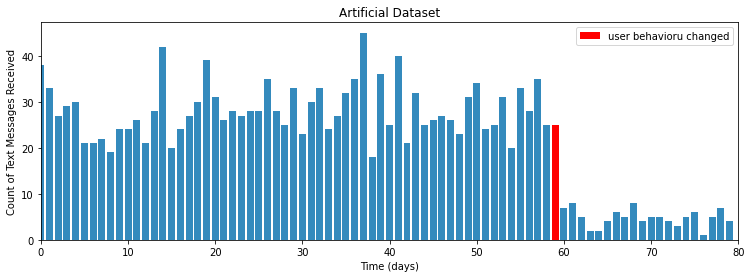

In [ ]:
# Plot the artificial dataset
plt.bar(np.arange(80), data, color = '#348ABD')
plt.bar(tau - 1, data[tau - 1], color = 'r', label = 'user behavioru changed')
plt.xlabel('Time (days)')
plt.ylabel('Count of Text Messages Received')
plt.title('Artificial Dataset')
plt.xlim(0, 80)
plt.legend()

It doesn't matter that the dataset we've generated doesn't look like the original dataset. It's because we've used random values for alpha, lambda, and tau. The whole point of Bayesian inference is to help us find values for these parameters that minimize the difference between our simulated data generating process and the actual data generating process.

In [ ]:
def plot_artificial_sms_dataset():
  tau = stats.randint.rvs(0, 80)
  alpha = 1.0 / 20.0 
  lambda_1, lambda_2 = stats.expon.rvs(scale = 1 / alpha, size = 2)
  data = np.r_[
               stats.poisson.rvs(mu = lambda_1, size = tau), 
               stats.poisson.rvs(mu = lambda_2, size = 80 - tau)
  ]
  plt.bar(np.arange(80), data, color = '#348ABD')
  plt.bar(tau - 1, data[tau - 1], color = 'r', label = 'user behaviour changed')
  plt.xlim(0, 80)

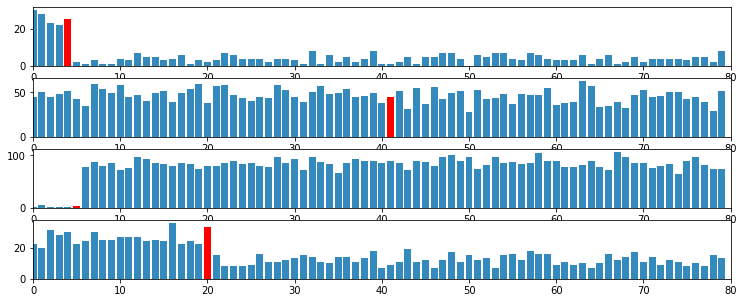

In [ ]:
figsize(12.5, 5)
plt.title('More examples of artificial datasets')
for i in range(4):
  plt.subplot(4, 1, i + 1)
  plot_artificial_sms_dataset()

# Example 01 - Bayesian A/B Testing

Assume $p_A$ is the probability that a customer purchases a product when they visit site A. We know that site A was shown to $N$ customers of which $n$ customers made purchases. 

We want to use this information to estimate the **true** value of $p_A$, which may not necessarily be the same as the observed value of $p_A = \frac{n}{N}$. 

The **true** value of such probabilities is often hidden from us. We need to infer it from the data. 

So, essentially 
$$P(A|X) = \frac{P(X|A)P(A)}{P(X|A)P(A) + P(X|A^C)P(A^C)}$$
$$Posterior = \frac{Likelihood \times Prior}{Normalizing Constant}$$

We need to define the prior and likelihood before we can proceed. 
We have no strong convictions or evidence about $p_A$ so we can assume a uniform prior: all values of $p_A \in [0, 1]$ are equally likely. 

## Site A Only

In [ ]:
import pymc3 as pm

In [ ]:
# Instantiate a model where a uniform distribution for th prior probability of sale on website A 
with pm.Model() as model:
  p = pm.Uniform('p', lower = 0, upper = 1)

In [ ]:
# Simulate some data assuming p_A = 0.05 and N = 1500. Use a binomial distribution to generate data.
p_true = 0.05                 # This is actually unknown. We are just assuming this for the sake of data generation
N = 1500                      # Number of observations 

# Sample N Bernoulli random variables from Ber(0.05). Each random variable has a 0.05 
# chance of being a 1. This is the data generation step
occurrences = stats.bernoulli.rvs(p_true, size = N)

print("Occurences: ", occurrences)
print("Total Sales: ", np.sum(occurrences))

Occurences:  [0 0 0 ... 0 0 0]
Total Sales:  77


In [ ]:
# The man value of `occurrences` is an estimate for the "true" probability of a sale 
print("What is the observed frequency in Group A? %.4f" % np.mean(occurrences))
print("Does this equal the true frequency? %s" % (np.mean(occurrences) == p_true))

What is the observed frequency in Group A? 0.0513
Does this equal the true frequency? False


We combine our observations into the PyMC3 model's `observed` variable and run our inference algorithm.

In [ ]:
with model:
  # The data used as the evidence to generate posterior
  obs = pm.Bernoulli('obs', p, observed = occurrences)
  
  # To be explained in chapter 3
  step = pm.Metropolis()                  # Use Metropolis proposals in MCMC sampling
  trace = pm.sample(18000, step = step)   # 18000 samples from the posterior distribution
  burned_trace = trace[1000:]             # Assume first 1k were warmups 

Sequential sampling (2 chains in 1 job)
Metropolis: [p]
100%|██████████| 18500/18500 [00:02<00:00, 6701.15it/s]
The number of effective samples is smaller than 25% for some parameters.


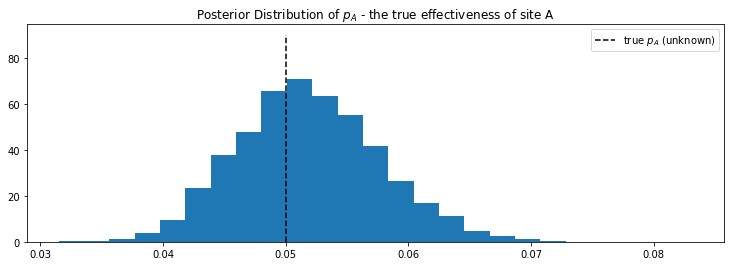

In [ ]:
# What does the posterior distribution of p_A look like?
figsize(12.5, 4)
plt.title('Posterior Distribution of $p_A$ - the true effectiveness of site A')
plt.vlines(p_true, 0, 90, linestyle = '--', label = 'true $p_A$ (unknown)')
plt.hist(burned_trace['p'], bins = 25, histtype = 'stepfilled', density = True) 
plt.legend()

The good thing about this approach is that instead of giving us a point estimate for the true probability of a sale on website A $p_A$, it returns a probability distribution. The deviation/width of the probability distribution is proportional to the uncertainty in the belief that the 'true' value of the probability distribution is the same as the man of the distribution.

The greater the number of observatons `N` in the data, the lower the 'width' of the posterior distribution, and thus the greater our confidence that it has the true value of $p_A$.

# Site A and B

We can carry out a similar analysis for both sites A and B simultaneously to determine $p_A$, $p_B$ and $\delta = p_A - p_B$ all at once with PyMC3.

For this exercise, we can assume that $p_A = 0.05, p_B = 0.04 \Rightarrow \delta = 0.01$ and that $N_B = 750$.

We simulate data for site B in much the same way as we did for site A.

In [ ]:
import pymc3 as pm
figsize(12, 4)

In [ ]:
# These two quantities are actually unknown to us, but for the sake of this example 
# we're assuming we know them a priori
true_p_A = 0.05 
true_p_B = 0.04 

# The unequal sample sizes for two sites aren't an issue in Bayesian Analysis
N_A = 1500
N_B = 750 

# Observations are still generating by a Bernoulli process 
observations_A = stats.bernoulli.rvs(true_p_A, size = N_A)
observations_B = stats.bernoulli.rvs(true_p_B, size = N_B)

# The observations - 1 denoting sale, 0 denoting no sale - are different for the two sites
[print(f"Observations from Site {site_letter}: {site_obs[:30]} ...") for (site_letter, site_obs) in zip(['A', 'B'], [observations_A, observations_B])]

# The conversion rate is also different
[print(f"Observed CR - Site {site_letter}: {np.mean(obs):.4f}") for (site_letter, obs) in zip(['A', 'B'], [observations_A, observations_B])]

Observations from Site A: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0] ...
Observations from Site B: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ...
Observed CR - Site A: 0.0533
Observed CR - Site B: 0.0413


[None, None]

In [ ]:
# Set up the PyMC3 model: again assumes a uniform prior for p_A and p_B
with pm.Model() as model:
  # Prior probabilities 
  p_A = pm.Uniform('p_A', 0, 1)
  p_B = pm.Uniform('p_B', 0, 1)

  # Define the deterministic delta function. This is our unknown of interest
  delta = pm.Deterministic('delta', p_A - p_B)

  # Evidence/set of observations. In this case, we have separate obs for each dataset
  obs_A = pm.Bernoulli('obs_A', p_A, observed = observations_A)
  obs_B = pm.Bernoulli('obs_B', p_B, observed = observations_B)

  # To be explained later in chapter 3 
  step = pm.Metropolis() 
  trace = pm.sample(20000, step = step)
  burned_trace = trace[1000:]

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]
100%|██████████| 20500/20500 [00:06<00:00, 3094.09it/s]
The number of effective samples is smaller than 25% for some parameters.


We can now extract the samples of the posterior distributions for $p_A, p_B, \delta$ and plot their histograms to visualize the results of our A/B testing.

In [ ]:
p_A_samples = burned_trace['p_A']
p_B_samples = burned_trace['p_B']
delta_samples = burned_trace['delta']

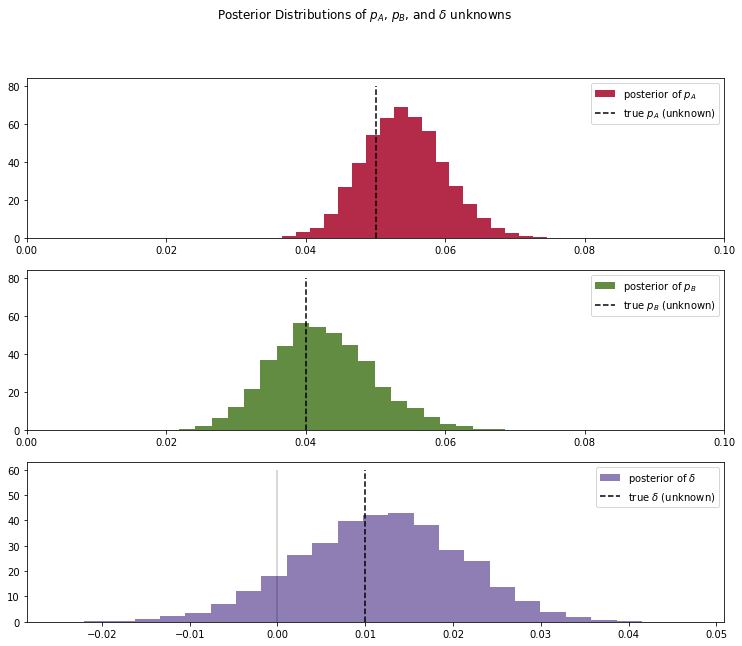

In [ ]:
figsize(12.5, 10)

plt.suptitle('Posterior Distributions of $p_A$, $p_B$, and $\delta$ unknowns')

# Histogram of posteriors - p_A
ax = plt.subplot(311)
plt.xlim(0, 0.1)
plt.hist(p_A_samples, histtype = 'stepfilled', bins = 25, alpha = 0.85, 
         label = 'posterior of $p_A$', color = '#A60628', density = True)
plt.vlines(true_p_A, 0, 80, linestyle = '--', label = 'true $p_A$ (unknown)')
plt.legend(loc = 'upper right')

ax = plt.subplot(312)
plt.xlim(0, 0.1)
plt.hist(p_B_samples, histtype = 'stepfilled', bins = 25, alpha = 0.85, 
         label = 'posterior of $p_B$', color = '#467821', density = True)
plt.vlines(true_p_B, 0, 80, linestyle = '--', label = 'true $p_B$ (unknown)')
plt.legend(loc = 'upper right')

ax = plt.subplot(313)
plt.hist(delta_samples, histtype = 'stepfilled', bins = 25, alpha = 0.85, 
         label = 'posterior of $\delta$', color = '#7A68A6', density = True)
plt.vlines(true_p_A - true_p_B, 0, 60, linestyle = '--', label = 'true $\delta$ (unknown)')
plt.vlines(0, 0, 60, color = 'black', alpha = 0.2)
plt.legend(loc = 'upper right')

Looking at the posterior distributions for our parameters, we can infer
1. $p_A$ has a narrower distribution than $p_B$ because the sample size $N_A$ for site A is twice that of $N_B$. So we are more 
2. This means we are more certain about the true value of $p_A$ than we are for the true value of $p_B$ **derived from these posterior distributions**. 
3. The posterior distribution for $\delta$ is mostly above 0. Since $\delta = p_A - p_B$, this means that the probability of a sale on site A is actually more likely to be higher than a probability of sale on site B. 

In [ ]:
# Confirming A > B
print(f"Probability that site A is WORSE than B: {np.mean(delta_samples < 0):.3f}")
print(f"Probability that site A is BETTER than B: {np.mean(delta_samples > 0):.3f}")

Probability that site A is WORSE than B: 0.108
Probability that site A is BETTER than B: 0.892


# The Binomial Distribution

In [ ]:
# Plotting the binomial probability mass distribution 
import scipy.stats as stats
import numpy as np

Text(0.5, 1.0, 'Probability Mass Distribution of Binomial Random Variables')

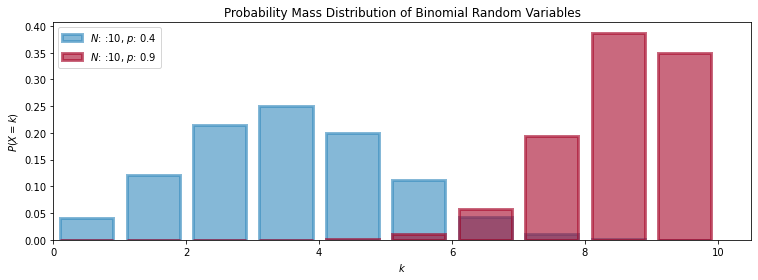

In [ ]:
figsize(12.5, 4)

parameters = [(10, 0.4), (10, 0.9)]       # (N, p) = (Number of trials, probability of 'success')
colors = ['#348ABD', '#A60628']     

# Demonstrate the effect of `p` on the distribution 
for i in range(2):
  # Unpack the tuple to find the number of trials and probability of success
  N, p = parameters[i]

  # The range of values of the binomial random variable
  _x = np.arange(N + 1)

  # We're plotting the probability of observing _x successes in N trials given probability of success = p 
  # To shift the xtick labels for the bars, the plt.bar's x_axis argument is offset by 0.5 
  plt.bar(_x - 0.5, binomial.pmf(_x, N, p), color = colors[i], 
          edgecolor = colors[i], alpha = 0.6, label = '$N$: :%d, $p$: %.1f' % (N, p), 
          linewidth = 3
  )

plt.legend(loc = 'upper left')
plt.xlim(0, 10.5)
plt.xlabel('$k$')
plt.ylabel('$P(X = k)$')
plt.title('Probability Mass Distribution of Binomial Random Variables')

# Example 02 - Cheating Among Students

We'll be using the binomial distribution to determine the frequency of students cheating on an exam. 

$N$ is the number of students who took the exam. 
$X$ is the number of students who respond in the affirmative when asked about if they cheated on the exam in a post-exam survey. 
$p$ is the probability that any given student cheated on the exam. 

We will use the binomial distribution to find the posterior distribution for $p$ - the probability that a student cheated on the exam given some specified prior $p$.

To get around the problem of dishonest answers, we'll use a privacy preserving algorithm:
1. Student flips a coin.
2. If coin is heads, the student answers honestly. 
3. If coin is tails, student flips the coin again. 
4. If the second coin toss is a heads, then student pleads guilty. 
5. If the second coin toss is a tails, then student pleads not guilty. 

This preserves privacy because the interviewer does not know if a guilty plea was due to the first coin toss or the second coin toss. 

This model will have some noise, but PyMC3 can be used to sift through it.

## Approach 01 
- 100 students are being surveyed. 
- Want to find $p$ - the 'true' proportion of students that cheated. 
- Since we are ignorant about $p$, assume a uniform prior. 

In [ ]:
import pymc3 as pm
import numpy as np

In [ ]:
N = 100                                           # Number of students surveyed

# Our model begins with a uniform prior called `freq_cheating` between 0 and 1
with pm.Model() as model:
  p = pm.Uniform('freq_cheating', 0, 1)

In [ ]:
# We assign a 1/0 cheating flag to each student based on a Bernoulli random variable 
# 1 implies they cheated. 0 Implies they did not 

with model:
  true_answers = pm.Bernoulli('truths',         # The component is called `truths` 
                              p,                # The probability of success - defined in the context of the model in the last cell
                              shape = N,        # We're generating such infomation for 100 students 
                              testval = np.random.binomial(1, 0.5, N))          # Randomly initialise the initial probability? 

In [ ]:
# The next step: first coin flip. There is 1/2 chance of heads or tails. 
# We arbitrarily choose to denote heads with 1 and tails with 0 
with model:
  first_coin_flips = pm.Bernoulli('first_flips', 0.5, shape = N, testval = np.random.binomial(1, 0.5, N))

In [ ]:
print(first_coin_flips.tag.test_value)          # Data generated by the Bernoulli process

[0 1 1 0 1 0 0 1 1 1 1 0 1 0 0 0 0 1 1 0 1 0 0 1 1 0 1 1 0 0 0 0 0 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 0 1 0 1 0 1 0 0 1 1 0 1 1 1 0 0 1 1
 0 1 1 0 0 1 1 0 0 0 1 1 0 0 1 0 0 1 1 0 0 0 0 0 0 1]


In [ ]:
# Although not everyone flipped a second time, we can model the possible realization of a second flip

with model:
  second_coin_flips = pm.Bernoulli('second_flips', 0.5, shape = N, testval = np.random.binomial(1, 0.5, N))

Using these variables, we can now return a possible realization of the observed proportion of 'Yes' responses using a PyMC3 deterministic variable.

The variable is deterministic here because it's individual components: `true_answers`, `first_coin_flips`, and `second_coin_flips` are all known to us before hand. 

In [ ]:
import theano.tensor as tt 

with model:
  """
  This is the heart of the privacy preserving algorithm. `val` is 1 if and only if 
  the first_coin_flips is 1 (heads on first toss, so student answers truthfully)
  and the true_answer is also 1. It is also 1 if the first_coin_flip is false
  and second_coin_flip is heads. Which means the that the student may not have 
  answered truthfully, but has plead guilty anyway. In all other cases, it is 0.
  """
  val = first_coin_flips * true_answers + (1 - first_coin_flips) * second_coin_flips 
  observed_proportion = pm.Deterministic('observed_proportion', tt.sum(val) / float(N))

We now have to add a dataset that can be used as the `obs` for our model. Suppose that we have received 35 yes responses.

To put these numbers into context:
If there were truly no cheaters among the students, then the only way we could have received any heads at all would have been $Tails_{t1} \times Heads_{t2}$ where $t_i$ is the $i^{th}$ toss. If tails on the first toss, then the student is forced to flip another coin instead of answering truthfully. On the second toss, if heads, then plead guilty. So $\frac{1}{2} \times \frac{1}{2} = \frac{1}{4}$. 

If there were only cheaters in the 100 students surveyed, then we could get a yes in two ways 
1. If all students answered truthfully on the first coin toss - $\frac{1}{2}$ OR
2. If all students had tails on the first coin toss and heads on the second: $\frac{1}{2} \times \frac{1}{2} = \frac{1}{4}$.

So the researchers observe a **binomial random variable** with $N$ = 100 and $p$ = `observed_proportion$ and $X$ = 35. 


In [ ]:
X = 35        # The number of observed 'yes, I cheated' responses 

with model:
  observations = pm.Binomial('obs', N, observed_proportion, observed = X)

We now add all the variables we have created to a model object and run our MCMC algorithm to sample from the posterior. 

In [ ]:
with model:
  step = pm.Metropolis(vars = [p])

  # 40k samples 
  trace = pm.sample(40 * (10 ** 3), step = step)

  # Of which 15k warmups
  burned_trace = trace[15 * (10 ** 3):]

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [freq_cheating]
>BinaryGibbsMetropolis: [truths, first_flips, second_flips]
100%|██████████| 40500/40500 [13:42<00:00, 49.26it/s]
The number of effective samples is smaller than 10% for some parameters.


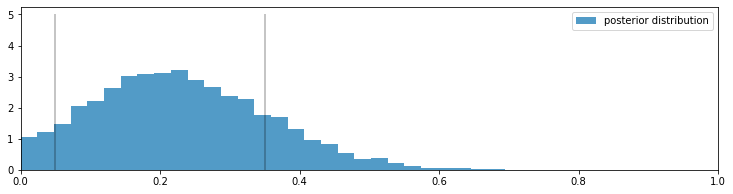

In [ ]:
figsize(12.5, 3)
p_trace = burned_trace['freq_cheating'][15000:]       # Only consider samples from the posterior after warmups

# Posterior distribution for `p` - the proportion of students who cheated
plt.hist(
    p_trace, histtype = 'stepfilled', density = True, alpha = 0.85, bins = 30, 
    label = 'posterior distribution', color = '#348ABD'
)

# Add vertical lines to find mark range of values with high probability
plt.vlines([0.05, 0.35], [0, 0], [5, 5], alpha = 0.3)

plt.xlim(0, 1)

plt.legend()

The plot shows that we have updated our prior - which was completely uninformative and assumed a uniform probability for the proportion of cheating students. Instead, we now know that the true proportion lies between 0.05 and 0.35. 

Posterior sampling has effectively ruled out the possibility that the proportion of cheaters is 0 or greater than upper_lim.

## Approach 02

Given a value for $p$, we can find the probability that the student will answer yes as follows. 

$P(Yes) = P(Heads~On~First~Try) \times P(cheater) + P(Tails~On~First~Coin)\times P(Heads~On~Second~Coin)$

$P(Yes) = \frac{1}{2}\times p + \frac{1}{2} \times \frac{1}{2}$

$P(Yes) = \frac{p}{2} + \frac{1}{4}$

In [ ]:
# Using this knowledge to generate a deterministic function for the probability of a 'Yes' 
with pm.Model() as model:
  # The prior proportion of cheating students is still uniform/uninformative
  p = pm.Uniform('freq_cheating', 0, 1)

  # But we can reformulate it in the following terms
  p_skewed = pm.Deterministic('p_skewed', 0.5 * p + 0.25)

If we now know the probability of respondents saying Yes, which is `p_skewed`, and we have $N = 100$ students, then the number of Yes responses is a binomial random variable with the parameters $N$ and $p_{skewed}$. 

We can then include the 35 yes observations as our data. 

In [ ]:
with model:
  yes_responses = pm.Binomial('number_cheaters', 100, p_skewed, observed = 35)

In [ ]:
# Now we add the variables of interest to the model and run our algorithm
with model:
  step = pm.Metropolis() 
  trace = pm.sample(25 * (10 ** 3), step = step)
  burned_trace = trace[2500:]

Sequential sampling (2 chains in 1 job)
Metropolis: [freq_cheating]
100%|██████████| 25500/25500 [00:03<00:00, 7621.49it/s]
The number of effective samples is smaller than 25% for some parameters.


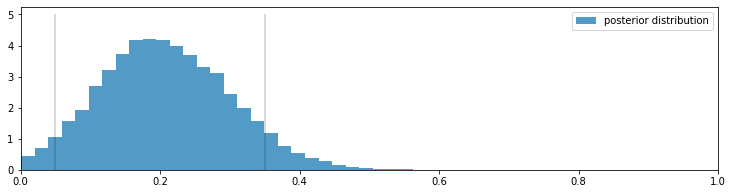

In [ ]:
figsize(12.5, 3)

p_trace = burned_trace['freq_cheating']
plt.hist(
    p_trace, histtype = 'stepfilled', density = True, alpha = 0.85, bins = 30, 
    label = 'posterior distribution', color = '#348ABD'
)

plt.vlines([0.05, 0.35], [0, 0], [5, 5], alpha = 0.2)

plt.xlim(0, 1)

plt.legend()

This is another approach of sampling the posterior distribution of `p`. 

# Example 03 - Challenger Disaster

## Challenger O-Ring Data

We will use Bayesian modeling to try and predict the chances of the Challenger disaster using only 24 data points about O-ring failure and temperature.

In [ ]:
import numpy as np 
import scipy as stats
import pymc3 as pm
import theano.tensor as tt

%matplotlib inline 

from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt 
import scipy.stats as stats

In [ ]:
!wget "https://raw.githubusercontent.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/master/Chapter2_MorePyMC/data/challenger_data.csv"

--2021-02-16 19:09:52--  https://raw.githubusercontent.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/master/Chapter2_MorePyMC/data/challenger_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 413 [text/plain]
Saving to: ‘challenger_data.csv.1’

challenger_data.csv 100%[===================>]     413  --.-KB/s    in 0s      

2021-02-16 19:09:53 (29.7 MB/s) - ‘challenger_data.csv.1’ saved [413/413]



Text(0.5, 1.0, 'Defects of the Space Shuttle O-Rings vs Temperature')

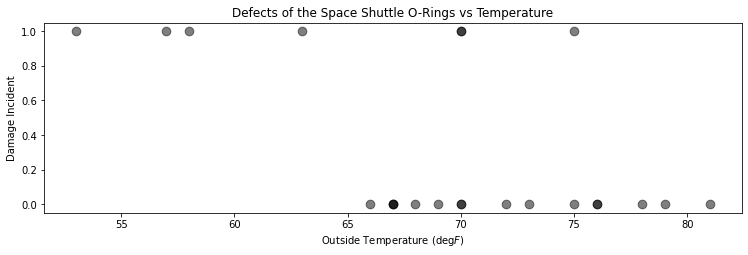

In [ ]:
figsize(12.5, 3.5)

np.set_printoptions(precision = 3, suppress = True)

# Read the data from CSV
challenger_data = np.genfromtxt("./challenger_data.csv", skip_header = 1, 
                                usecols = [1, 2], missing_values = 'NA', delimiter = ',')

# Drop the NAN values 
challenger_data = challenger_data[~np.isnan(challenger_data[:, 1])]

# Plot O-ring failure as a function of temperature 
plt.scatter(challenger_data[:, 0], challenger_data[:, 1], s = 75, color = 'k', alpha = 0.5)
plt.ylabel('Damage Incident')
plt.xlabel('Outside Temperature $(\deg F)$')
plt.title('Defects of the Space Shuttle O-Rings vs Temperature')

It doesn't look like there is a single cutoff temperature which distinguishes O-ring failure region from non-failure region.

So it makes more sense to model the probability of O-ring failure at time $t$.

We need a function of temperature $p(t)$ that is $\in [0, 1]$. More specifically, this function should decrease from 0 to 1 as $t$ increases. 

The logistic function is a good choice 
$p(t) = \frac{1}{1 + e^{\beta t}}$.

In this model, $\beta$ is a variable that we are uncertain about.

## Plotting Logistic Function

In [ ]:
# Define the exponential function for some x (domain) and beta (parameter)
def logistic(x, beta):
  return 1.0 / (1 + np.exp(beta * x))

Text(0.5, 1.0, 'Logistic Function for Different $\\beta$')

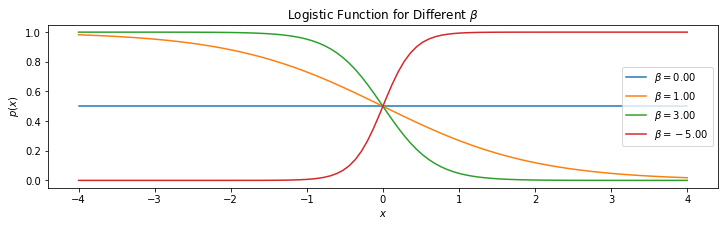

In [ ]:
figsize(12, 3)

x = np.linspace(-4, 4, 100)

for beta in [0, 1, 3, -5]:
  legend_str = r'$\beta = %.2f$' % beta
  plt.plot(x, logistic(x, beta), label = legend_str)

plt.legend()
plt.xlabel('$x$')
plt.ylabel('$p(x)$')
plt.title(r'Logistic Function for Different $\beta$')

The issue with the standard logistic function is that it's inflection point is at 0: it changes near zero. But in our O-ring data, we can visualize a logistic function changing near 65 or 70. So we add an offset to the logistic function.

$p(t) = \frac{1}{1 + e^{\beta t + \alpha}}$

In [ ]:
def logistic(x, beta, alpha = 0):
  return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))

Text(0.5, 1.0, 'Effect of $\\alpha$ and $\\beta$ on logistic function')

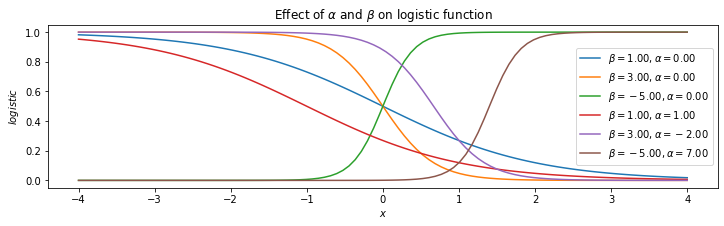

In [ ]:
x = np.linspace(-4, 4, 100)

my_betas = [1, 3, -5, 1, 3, -5]
my_alphas = [0, 0, 0, 1, -2, 7]

for my_beta, my_alpha in zip(my_betas, my_alphas):
  plot_label = rf"$\beta = {my_beta:.2f}, \alpha = {my_alpha:.2f}$"
  plt.plot(x, logistic(x, beta = my_beta, alpha = my_alpha), label = plot_label)

plt.xlabel('$x$')
plt.ylabel('$logistic$')
plt.legend()
plt.title(r'Effect of $\alpha$ and $\beta$ on logistic function')

So adding $\alpha$ shifts the curve left or right, which is why it is called a bias. 

## The Normal Distribution

$\alpha$ and $\beta$ have no reason to be extremely large, are not necessarily bounded or positive. So they can be modeled with a normal distribution. 

The normal distribution has two parameters 
- $\mu$: the mean 
- $\tau^{-1}$: the reciprocal of $\sigma^2$. The larger the value of $\tau$, the tighter the "spread" of the distribution. $\tau$ is always positive. 


Text(0.5, 1.0, 'Probability Distribution of three different normal random variables')

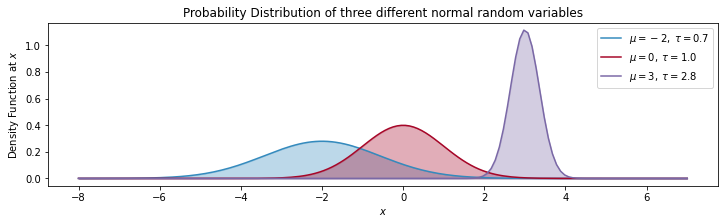

In [ ]:
# Initialize a normal distribution object 
nor = stats.norm 

# `x` is the domain of values for which we will plot the logistic function
x = np.linspace(-8, 7, 150)

# Different parameters for normal distributions along with color codes
mu = (-2, 0, 3)
tau = (0.7, 1, 2.8)
colors = ['#348ABD', '#A60628', '#7A68A6']

# Make each combination a single tuple
parameters = zip(mu, tau, colors)

# For each combo of mean, tau, and color, make a plot
for _mu, _tau, _color in parameters:
  plt.plot(x, nor.pdf(x, _mu, scale = 1./_tau), 
           label = '$\mu = %d,\; \\tau = %.1f$' % (_mu, _tau), color = _color)
  plt.fill_between(x, nor.pdf(x, _mu, scale = 1./_tau), color = _color, 
                   alpha = 0.33)
  
# Annotate it
plt.legend(loc = 'upper right')
plt.xlabel('$x$')
plt.ylabel('Density Function at $x$')
plt.title('Probability Distribution of three different normal random variables')

## Modeling The Challenger
To recap 
- the outcome of an O-ring failure is best modeled as a Bernoulli randon variable: there will be only one trial (one launch) parameterized by the probability of failure $p$. 
- we have decided that the probability of O-ring failure $p$ will be modeled by the logistic function $\frac{1}{1 + e^{\beta t + \alpha}}$.
- the logistic function has two parameters, $\alpha$ and $\beta$. 
- $\alpha$ and $\beta$ are to be modeled as normal random variables.

In [ ]:
temperature = challenger_data[:, 0]
defect = challenger_data[:, 1]      

In [ ]:
defect

array([0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 1.])

In [ ]:
with pm.Model() as model:
  """
  We explicitly initialize beta and alpha to 0. Too large a value of a beta or alpha
  can make p = 0 or 1. This can cause problems with pm.Bernoulli, since it does
  not like probabilities of exactly 0 or 1. Initializing these params to 0 means
  p has a reasonable starting value. It does not affect our results - just a 
  computational caveat for compatibility with PyMC3
  """
  beta = pm.Normal('beta', mu = 0, tau = 0.001, testval = 0)
  alpha = pm.Normal('alpha', mu = 0, tau = 0.001, testval = 0)

  # tt is a Theano tensor
  p = pm.Deterministic('p', 1.0 / (1 + tt.exp(beta * temperature + alpha)))

In [ ]:
# Connect the probabilities in `p` with the observations in `defect` through a 
# Bernoulli random variable 

with model:
  observed = pm.Bernoulli('bernoulli_obs', p, observed = defect)

  # MCMC 
  start = pm.find_MAP()       # Maximum apriori?
  step = pm.Metropolis()
  trace = pm.sample(120 * (10 ** 3), step = step, start = start)
  burned_trace = trace[10 * (10 **3)::2]

/usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -19.024, ||grad|| = 9.9071: 100%|██████████| 27/27 [00:00<00:00, 1376.22it/s]  
Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [alpha]
>Metropolis: [beta]
100%|██████████| 120500/120500 [00:33<00:00, 3639.34it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


Now that we have trained our model on the observed data, we can sample from the posterior distributions for $\alpha$ and $\beta$, and then use these distributions to derive $p$.

In [ ]:
alpha_samples = burned_trace['alpha'][:, None]      # Best to make samples 1-D
beta_samples = burned_trace['beta'][:, None]

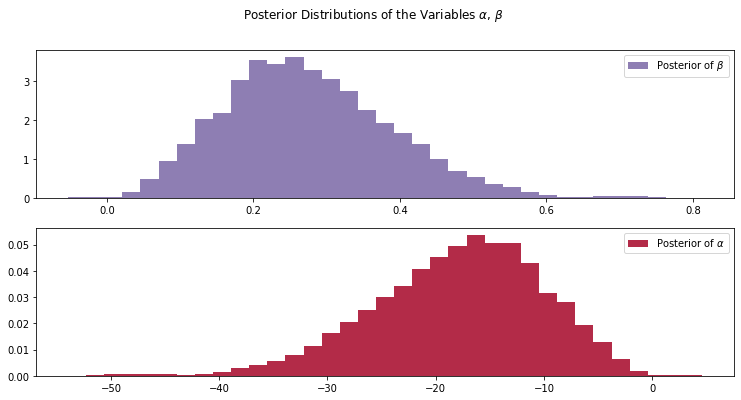

In [ ]:
# Plot the posterior distributions for apha and beta 
figsize(12.5, 6)

# Beta
plt.subplot(211)
plt.hist(beta_samples, histtype = 'stepfilled', bins = 35, alpha = 0.85, 
         label = r'Posterior of $\beta$', color = '#7A68A6', density = True)
plt.legend()

# Alpha
plt.subplot(212)
plt.hist(alpha_samples, histtype = 'stepfilled', bins = 35, alpha = 0.85, 
         label = r'Posterior of $\alpha$', color = '#A60628', density = True)

plt.suptitle(r'Posterior Distributions of the Variables $\alpha$, $\beta$')
plt.legend()

## Posterior Analysis
- The posterior distributions for both parameters have a very large spread, so we can't be very certain about the "true" value of these parameters. 
- Almost all of the density for $\alpha$ lies below 0: $\alpha$ is most likely a negative parameter. 
- Almost all of the density for $\beta$ lies above 0: $\beta$ is therefore likely to be a positive parameter. 
- Had $\beta$ been centered around 0, we could have assumed that temperature has no effect on defect rate.

## Predicting $p$ 

Now that we have distributions for $\alpha$ and $\beta$, we can make a distribution for $p$ - the probability of a defect in the O-ring for all values of $alpha$ and $\beta$. 

We will average over all samples from the posterior to get a likely value for $p(t_i)$ where $t_i$ is the temperature on the $i^{th}$ day.

In [ ]:
# Make a 1-D array of the domain of temperature values to plot probability for
t = np.linspace(temperature.min() - 5, temperature.max() + 5, 50)[:, None]

# Compute the temperature probability for each temperature for each pair of alpha, beta
p_t = logistic(t.T, beta_samples, alpha_samples)

In [ ]:
# There are 50 temperature measurements. For each of them, we have found the 
# probability of O-ring failure for each pair of alpha, beta drawn from the posterior
p_t.shape

(110000, 50)

In [ ]:
# We can find the expected value of p_t by averging along the columns
mean_prob_t = p_t.mean(axis = 0)

In [ ]:
mean_prob_t.shape       # One expected probability for each temperature

(50,)

Text(0, 0.5, 'Probability')

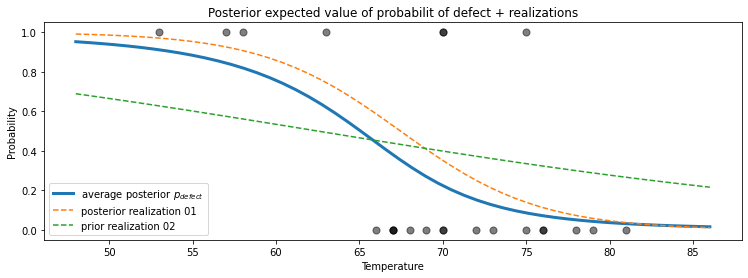

In [ ]:
figsize(12.5, 4)

plt.plot(t, mean_prob_t, lw = 3, label = 'average posterior $p_{defect}$')
plt.plot(t, p_t[0, :], linestyle = '--', label = 'posterior realization 01')
plt.plot(t, p_t[-2, :], linestyle = '--', label = 'prior realization 02')
plt.scatter(temperature, defect, color = 'k', s = 50, alpha = 0.5)
plt.title('Posterior expected value of probabilit of defect + realizations')
plt.legend(loc = 'lower left')
plt.xlabel('Temperature')
plt.ylabel('Probability')

A posterior realization is simply a set of predicted probabilities of failure $p$ for each draw of $\alpha$ and $\beta$ from the posterior distribution. 

The first posterior realization is very similar to the average posterior, while the second last is very dissimilar: almost linear. 

According to the book, either realization is as likely as the other. 

The blue solid line is what we get when we average over all 20,000 possible dotted lines. 

## Confidence Intervals 

At what temperatures are we most uncertain about the defect-probability? 

To visualize this, we plot the expected value **and** the associated 95% intervals for each temperature.

In [ ]:
from scipy.stats.mstats import mquantiles

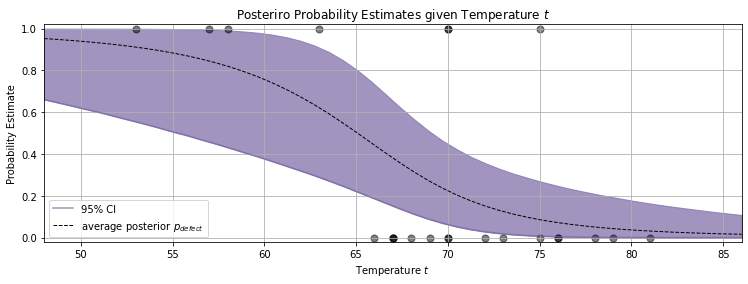

In [ ]:
# Vectorized bottm and top 2.5% quantiles for 'confidence interval' (credible interval?)
qs = mquantiles(p_t, [0.025, 0.975], axis = 0)
plt.fill_between(t[:, 0], *qs, alpha = 0.7, color = '#7A68A6')
plt.plot(t[:, 0], qs[0], label = '95% CI', color = '#7A68A6', alpha = 0.7)
plt.plot(t, mean_prob_t, lw = 1, ls = '--', color = 'k', 
         label = 'average posterior $p_{defect}$')
plt.xlim(t.min(), t.max())
plt.ylim(-0.02, 1.02)
plt.legend(loc = 'lower left')
plt.scatter(temperature, defect, color = 'k', s = 50, alpha = 0.5)
plt.xlabel('Temperature $t$')
plt.ylabel('Probability Estimate')
plt.title('Posteriro Probability Estimates given Temperature $t$')

plt.grid()

The 95% credible interval is coloured in purple, and represents the interval of probabilities that contains 95% of the distribution. 

What this means is that for a temperature like 65 degrees, we can be 95% sure that the "true" probability of defect lies between 0.22 and 0.80. 

This is useful information because we can tell that we are most uncertain about the probability of defect at lower temperatures between 60 - 65. It might be worthwhile to test O-rings at temperatures in that range to get more data and thus better estimate of probabilities in that range. 

## Challenger Inference

We can now use our model to predict the probability of an O-Ring failure on the day of the Challenger disaster: when the temperature was 31 degrees.

In [ ]:
# Once again, for all 110k samples of beta and alpha, we can predict a probability
prob_at_31_deg = logistic(x = 31, beta = beta_samples, alpha = alpha_samples)
prob_at_31_deg.shape

(110000, 1)

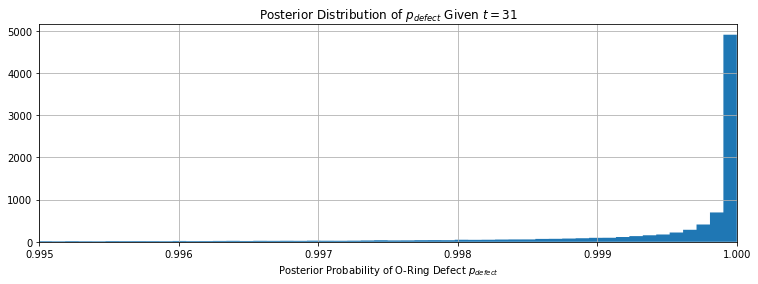

In [ ]:
# Plot the distribution of the predicted probabilities 
plt.xlim(0.995, 1)
plt.hist(prob_at_31_deg, bins = 10000, density = True, histtype = 'stepfilled')
plt.title('Posterior Distribution of $p_{defect}$ Given $t = 31$')
plt.xlabel('Posterior Probability of O-Ring Defect $p_{defect}$')
plt.grid()

Based on our statistical model, it looks like an O-ring failure was almost certain on the day of the challenger disaster. 

# Goodness of Fit 
- We could have chosen a function $p(t) = 1~\forall t$ that would have also predicted O-ring failure, regardless of $\alpha$ or $\beta$. 
- We could also have chosen a different prior for $\alpha$ of $\beta$ that had lower deviation around 0. 
- But to choose a "correct" model, we have to use a measure of "goodness of fit".
- If our model is correct, then working backwards, any data we generate from this model should be similar to observed data.
- More specifically, we sample from the posterior distribution to create a **stochastic variable** representing our data generating process. 
- We do this by creating a new model that is exactly the same as our old model, but without the data/`obs`.

In [ ]:
# Number of samples to draw from the posterior
N = 10000

with pm.Model() as model:
  # We beging by respecifying our model
  # Alpha and beta are parameters of a logistic function and are normally distributed
  beta = pm.Normal('beta', mu = 0, tau = 0.001, testval = 0)
  alpha = pm.Normal('alpha', mu = 0, tau = 0.001, testval = 0)

  # The probability of defect is paramerized by alpha and beta with the logistic function
  p = pm.Deterministic('p', 1.0 / (1.0 + tt.exp(beta * temperature + alpha)))

  # This is the "true" data of O-ring defects
  observed = pm.Bernoulli('bernoulli_obs', p, observed = defect)

  # This is the "simulated" data of O-ring defects. 
  simulated = pm.Bernoulli('bernoulli_simulated', p, shape = p.tag.test_value.shape)
  step = pm.Metropolis(vars = [p])
  trace = pm.sample(N, step = step)

Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [beta]
>>Metropolis: [alpha]
>BinaryGibbsMetropolis: [bernoulli_simulated]
100%|██████████| 10500/10500 [00:19<00:00, 547.78it/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [ ]:
# Extract the simulations data - note how we now have 23-dimensional data 
# instead of 50-dimensional data. Each row represents the simulated defect flag 
# for each of the 20k samples we have drawn from the posterior.
simulations = trace['bernoulli_simulated']
print(simulations.shape)

(20000, 23)


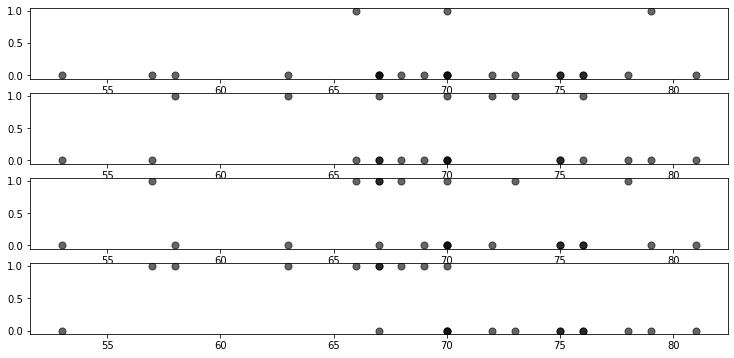

In [ ]:
plt.title('Simulated Dataset Using Posterior Parameters')
figsize(12.5, 6)
for i in range(4):
  # Four rows, one column - increment row number 
  ax = plt.subplot(4, 1, i + 1)

  # Plot the 1000th, 2000th, 3000th, and 4000th sampling of the simulated defect flags
  plt.scatter(temperature, simulations[1000 * i, :], color = 'k', 
              s = 50, alpha = 0.6)

For each data point in our defects data, find the posterior probability of a defect by computing the proportion of times the posterior simulation proposed a value for 1 for a particular temperature i.e. $P(Defect = 1 | \alpha, \beta, t)$.

In [ ]:
posterior_probability = simulations.mean(axis = 0)

In [ ]:
print("Posterior Probability of Defect | Realized Defect")
for i in range(len(defect)):
  print(f"{posterior_probability[i]:.2f}\t\t\t\t|\t{defect[i]}")

Posterior Probability of Defect | Realized Defect
0.44				|	0.0
0.23				|	1.0
0.27				|	0.0
0.32				|	0.0
0.38				|	0.0
0.15				|	0.0
0.13				|	0.0
0.22				|	0.0
0.81				|	1.0
0.61				|	1.0
0.23				|	1.0
0.06				|	0.0
0.38				|	0.0
0.88				|	1.0
0.38				|	0.0
0.10				|	0.0
0.23				|	0.0
0.05				|	0.0
0.09				|	0.0
0.05				|	0.0
0.09				|	1.0
0.08				|	0.0
0.79				|	1.0


In [ ]:
!wget "https://raw.githubusercontent.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/master/Chapter2_MorePyMC/separation_plot.py"

--2021-02-16 20:33:33--  https://raw.githubusercontent.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/master/Chapter2_MorePyMC/separation_plot.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1374 (1.3K) [text/plain]
Saving to: ‘separation_plot.py’

separation_plot.py  100%[===================>]   1.34K  --.-KB/s    in 0s      

2021-02-16 20:33:33 (47.2 MB/s) - ‘separation_plot.py’ saved [1374/1374]



In [ ]:
from separation_plot import separation_plot

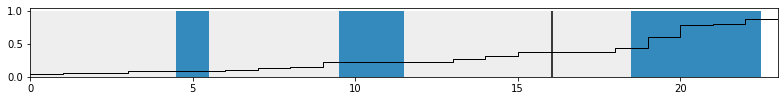

In [ ]:
figsize(11., 1.5)
separation_plot(posterior_probability, defect)

As the posterior probability of defect - denoted by the black line - rises, so, too, does the frequncy of true observed defects i.e. blue bars. 

Ideally, all the blue bars should be on the right of the plot i.e. in regions where the posterior probability of defect increases. 

Blue bars earlier in the plot are regions where a defect was observed in the "true" data but the posterior probability of a defect was not necessarily high. These are missed predictions. 

The black line is the expected number of dects we should observe given this specific model. 

It is more useful to generate such plots for multiple models.

Text(0.5, 1.0, 'Constant-Prediction Model')

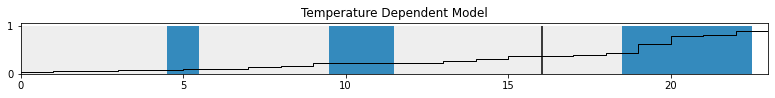

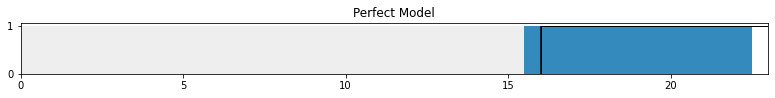

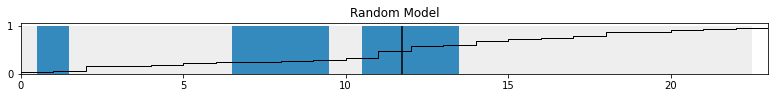

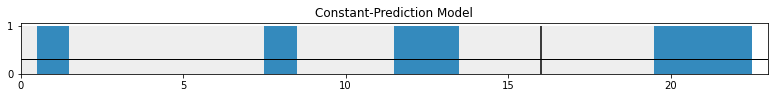

In [ ]:
figsize(11., 1.25)

# Our temperature dependent model 
separation_plot(posterior_probability, defect)
plt.title('Temperature Dependent Model')

# Perfect model i.e. the probability of defect is equal to if a defect occurred or not 
p = defect 
separation_plot(p, defect)
plt.title('Perfect Model')

# Random Predictions
p = np.random.rand(23)
separation_plot(p, defect)
plt.title('Random Model')

# Constant Model
constant_prob = 7. / 23 * np.ones(23)   # 7 defects, 23 observations 
separation_plot(constant_prob, defect)
plt.title('Constant-Prediction Model')